In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [0]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')

In [7]:
train_identity.head(), train_transaction.head(), test_identity.head(), test_transaction.head()

(   TransactionID  id_01  ...  DeviceType                     DeviceInfo
 0        2987004    0.0  ...      mobile  SAMSUNG SM-G892A Build/NRD90M
 1        2987008   -5.0  ...      mobile                     iOS Device
 2        2987010   -5.0  ...     desktop                        Windows
 3        2987011   -5.0  ...     desktop                            NaN
 4        2987016    0.0  ...     desktop                          MacOS
 
 [5 rows x 41 columns],
    TransactionID  isFraud  TransactionDT  ...  V337 V338  V339
 0        2987000        0          86400  ...   NaN  NaN   NaN
 1        2987001        0          86401  ...   NaN  NaN   NaN
 2        2987002        0          86469  ...   NaN  NaN   NaN
 3        2987003        0          86499  ...   NaN  NaN   NaN
 4        2987004        0          86506  ...   0.0  0.0   0.0
 
 [5 rows x 394 columns],
    TransactionID  id_01     id_02  ...  id_38  DeviceType                   DeviceInfo
 0        3663586  -45.0  280290.0  .

### Method to reduce memory

In [0]:
def reduce_memory(df):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    init_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_col = df[col].max()
            min_col = df[col].min()
            if str(vt)[:3] == 'int':
                if min_col > np.iinfo(np.int8).min and max_col < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_col > np.iinfo(np.int16).min and max_col < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_col > np.iinfo(np.int32).min and max_col < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_col > np.iinfo(np.int64).min and max_col < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_col > np.finfo(np.float16).min and max_col < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_col > np.finfo(np.float32).min and max_col < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_col > np.finfo(np.float64).min and max_col < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    reduced_mem = df.memory_usage().sum() / 1024**2
    print('Memory reduced to {:5.2f} Mb ({:.1f}% reduction)'.format(reduced_mem, 100 * (init_mem - reduced_mem) / init_mem))
    return df

In [9]:
train_identity = reduce_memory(train_identity)
train_transaction = reduce_memory(train_transaction)
test_identity = reduce_memory(test_identity)
test_transaction = reduce_memory(test_transaction)

Memory reduced to 25.86 Mb (42.7% reduction)
Memory reduced to 542.35 Mb (69.4% reduction)
Memory reduced to 25.44 Mb (42.7% reduction)
Memory reduced to 472.59 Mb (68.9% reduction)


### Merge both transaction and identity files

In [0]:
train_data = pd.merge(train_transaction, train_identity, on='TransactionID', how = 'left')
test_data = pd.merge(test_transaction, test_identity, on='TransactionID', how = 'left')

In [0]:
# Delete the files to reduce memory
del train_identity
del train_transaction
del test_identity
del test_transaction

In [69]:
train_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [15]:
test_data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2636.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# Find which columns has more than 50% of its data as null or NaN
null_prcnt = train_data.isnull().sum() / train_data.shape[0] * 100
cols_to_drop = np.array(null_prcnt[null_prcnt > 50].index)
cols_to_drop # This columns will be excluded since it contains too much of NaN values.

array(['dist1', 'dist2', 'R_emaildomain', 'D5', 'D6', 'D7', 'D8', 'D9',
       'D12', 'D13', 'D14', 'M5', 'M7', 'M8', 'M9', 'V138', 'V139',
       'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147',
       'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',
       'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163',
       'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171',
       'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179',
       'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187',
       'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195',
       'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203',
       'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
       'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219',
       'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227',
       'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235',
       '

In [71]:
# Drop the columns
train = train_data.drop(cols_to_drop, axis=1)
test = test_data.drop(cols_to_drop, axis=1)
train.shape, test.shape

((590540, 220), (506691, 219))

In [72]:
# Find which columns has some null or NaN so it can be replaced
null_prcnt = test.isnull().sum()/train.shape[0]*100
cols_to_fill = np.array(null_prcnt[null_prcnt > 0].index)
cols_to_fill

array(['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'V1', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39',
       'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48',
       'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57',
       'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66',
       'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75',
       'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84',
       'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93',
       'V94', 'V

In [0]:
# Replace NaN values by the columns mode
for i in cols_to_fill:
    train[i] = train[i].replace(np.nan, train[i].mode()[0])
    test[i] = test[i].replace(np.nan, train[i].mode()[0])

In [0]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [75]:
# Separate between the categorical and numerical data
cat_data = train.select_dtypes(include='object')
num_data = train.select_dtypes(exclude='object')

cat_cols = cat_data.columns.values
num_cols = num_data.columns.values

cat_cols

array(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3',
       'M4', 'M6'], dtype=object)

In [76]:
num_cols

array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2',
       'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12',
       'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D10', 'D11', 'D15', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74',
       'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',
       'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92',
       'V93', 'V

## Plotting

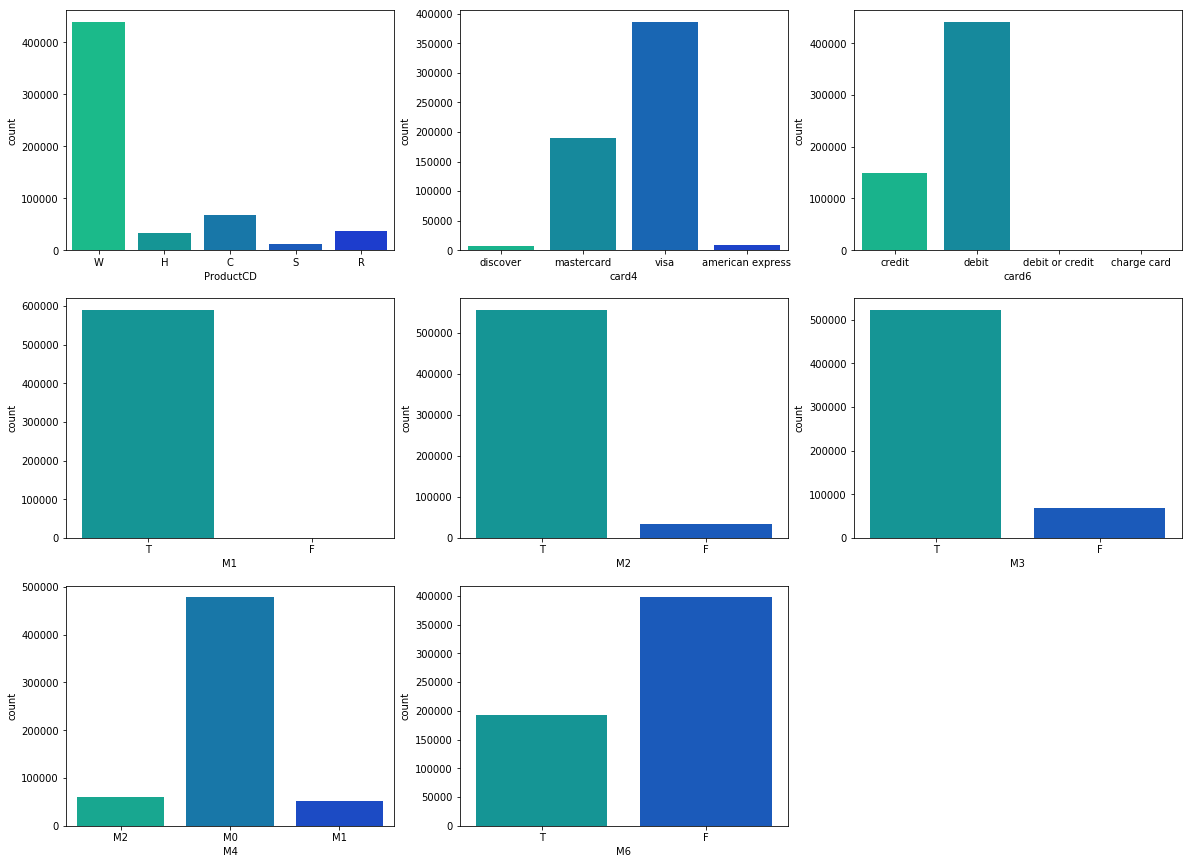

In [85]:
# Separate between Train and Test
X = train.drop('isFraud', axis=1)
y = train['isFraud']

# Plot the categorical columns
fig = plt.figure(figsize=(20,15))
j = 1
for i in cat_cols:
    if(i == 'P_emaildomain'):
        continue
    plt.subplot(3,3,j)
    sns.countplot(x=X[i], palette='winter_r')
    j = j + 1
    
plt.show()

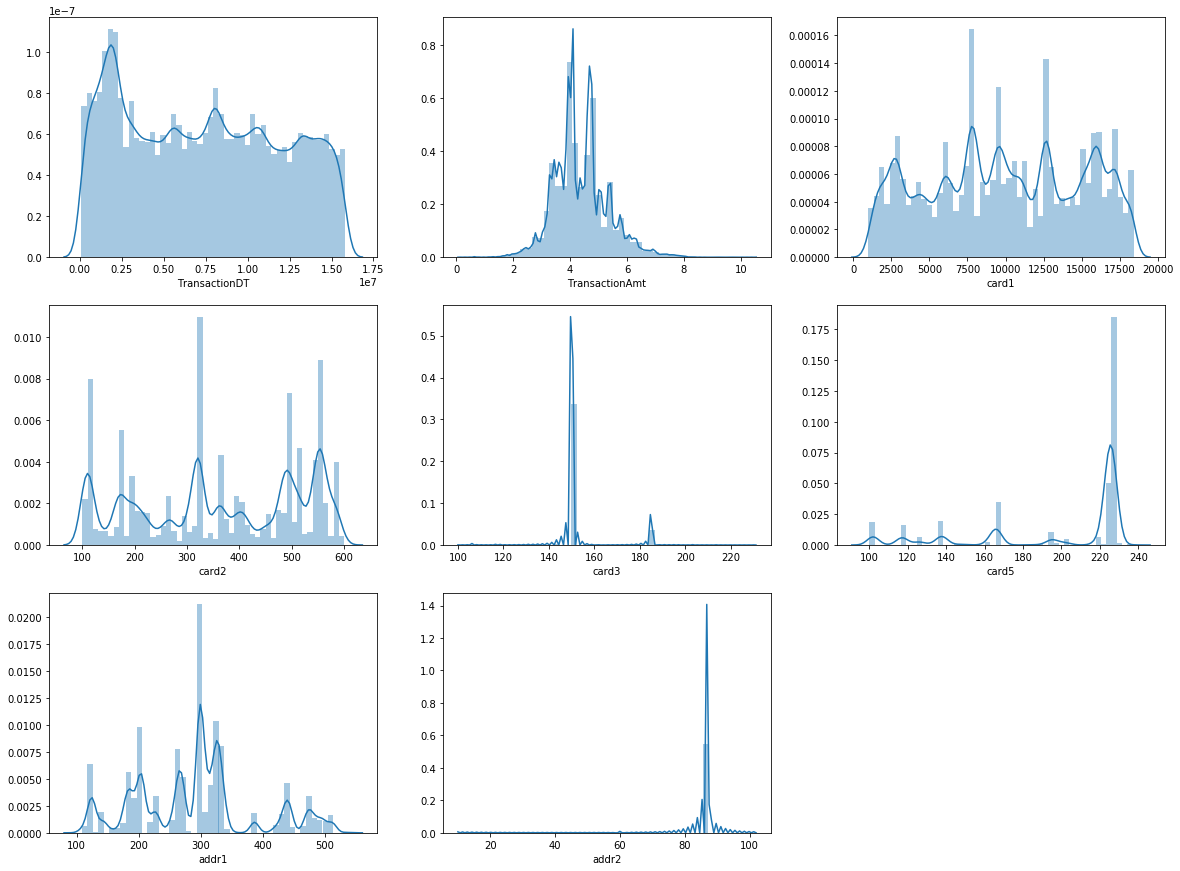

In [86]:
fig = plt.figure(figsize=(20,15))
j = 1
for i in num_cols[1:10]:
    if (i == 'isFraud'):
        continue
    plt.subplot(3,3,j)
    sns.distplot(a=X[i])
    j = j + 1
    
plt.show()

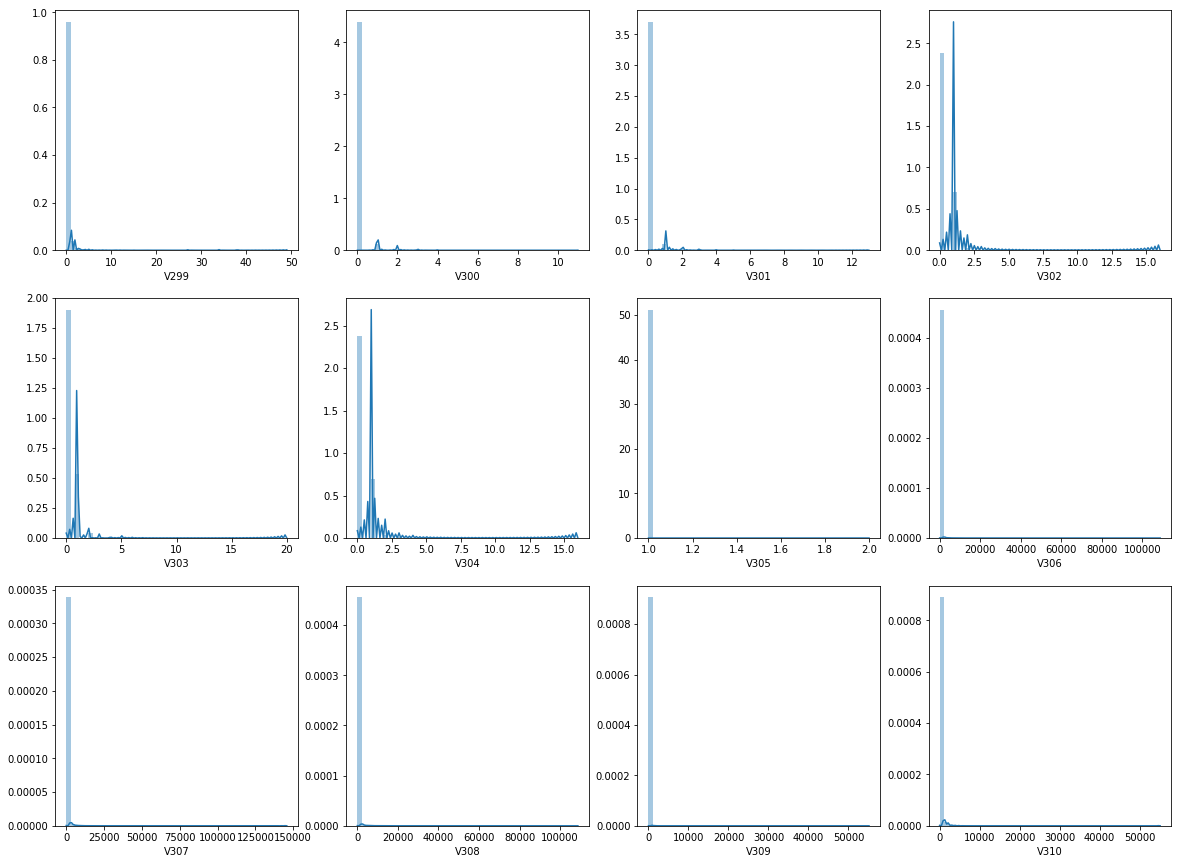

In [87]:
fig = plt.figure(figsize=(20,15))
j = 1
for i in num_cols[-23:-11]:
    plt.subplot(3,4,j)
    sns.distplot(a=X[i])
    j = j + 1
    
plt.show()

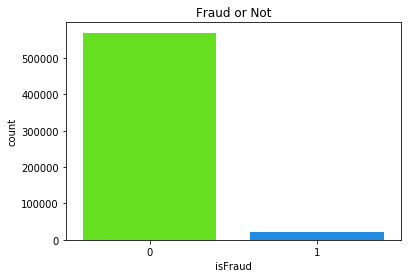

In [88]:
# Plot the fraud and non fraud transactions
sns.countplot(x=y, palette='gist_rainbow')
plt.title('Fraud or Not')
plt.show()

In [0]:
# Separate the Features and label and make categorical into numbers
train_dummies = pd.get_dummies(train)
X = train_dummies.drop('isFraud', axis=1)
X = X.fillna(0)
y = train_dummies['isFraud']

## Logistic Regression

In [90]:
lr = LogisticRegression()
lr.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
# Cross Validation
score = cross_val_score(lr, X, y, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .................................... , score=0.965, total=  19.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.7s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .................................... , score=0.965, total=  15.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.2s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[CV] .................................... , score=0.958, total=  14.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.4s finished


0.9627781277902647